## Prepare Environment

Import the required libraries and set the SQL analytic environment.

In [1]:
import pandas as pd

%load_ext sql
%config SqlMagic.autopandas = True
%sql duckdb:///:default:

Tip: You may define configurations in /workspaces/servier-de-python-test/pyproject.toml or /home/vscode/.jupysql/config.

Connecting to 'duckdb:///:default:'

## Pipeline Configuration

Get the pipeline options from the notebook arguments and set the default
values.

In [2]:
transaction_dataset_path = (
    input("Transaction dataset path:") or "../data/sql/TRANSACTION.csv"
)
transaction_synthetic_dataset_path = (
    input("Transaction synthetic dataset path:")
    or "../data/sql/TRANSACTION_SYNTHETIC.csv"
)
product_nomenclature_dataset_path = (
    input("Product nomenclature dataset path:")
    or "../data/sql/PRODUCT_NOMENCLATURE.csv"
)

## Data Loading

Load the data from the CSV and JSON files provided by the options ahead.

In [5]:
%%sql fct_transaction << --save fct_transaction
SELECT
    order_id,
    client_id,
    prod_id AS product_id,
    prod_price AS product_price,
    prod_qty AS product_quantity,
    date,
FROM
    '{{transaction_dataset_path}}'

Running query in 'duckdb:///:default:'

In [12]:
fct_transaction.describe(include="all")

,order_id,client_id,product_id,product_price,product_quantity,date
count,5.000000,5.000000,5.000000,5.000000,5.000000,5
mean,2567.200000,906.600000,442867.600000,82.712000,2.800000,2001-01-20 00:00:00
min,1234.000000,845.000000,293718.000000,3.560000,1.000000,2001-01-20 00:00:00
25%,1234.000000,845.000000,389728.000000,10.000000,1.000000,2001-01-20 00:00:00
50%,3456.000000,845.000000,490756.000000,50.000000,2.000000,2001-01-20 00:00:00
75%,3456.000000,999.000000,490756.000000,50.000000,4.000000,2001-01-20 00:00:00
max,3456.000000,999.000000,549380.000000,300.000000,6.000000,2001-01-20 00:00:00
std,1217.039523,84.349274,101243.406367,123.396008,2.167948,NaN


In [7]:
%%sql dim_product_nomenclature << --save dim_product_nomenclature
SELECT
    product_id,
    product_type,
    product_name,
FROM
    '{{product_nomenclature_dataset_path}}'

Running query in 'duckdb:///:default:'

In [11]:
dim_product_nomenclature.describe(include="all")

,product_id,product_type,product_name
count,4.000000,4,4
unique,NaN,2,4
top,NaN,MEUBLE,Chaise
freq,NaN,2,1
mean,430895.500000,NaN,NaN
std,112744.971452,NaN,NaN
min,293718.000000,NaN,NaN
25%,365725.500000,NaN,NaN
50%,440242.000000,NaN,NaN
75%,505412.000000,NaN,NaN


## Generate Synthetic Data

As the dataset is small, we will generate synthetic data to increase the
dataset size and variance.

In [ ]:
from langchain.chat_models.openai import ChatOpenAI
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from langchain_experimental.tabular_synthetic_data.openai import (
    OPENAI_TEMPLATE,
    create_openai_data_generator,
)
from langchain_experimental.tabular_synthetic_data.prompts import (
    SYNTHETIC_FEW_SHOT_PREFIX,
    SYNTHETIC_FEW_SHOT_SUFFIX,
)
from langchain_experimental.pydantic_v1 import BaseModel

example_prompt_template = PromptTemplate(
    input_variables=[
        "order_id",
        "client_id",
        "product_id",
        "product_price",
        "product_quantity",
        "date",
    ],
    template=(
        "Order ID: {order_id}, "
        "Client ID: {client_id}, "
        "Product ID: {product_id}, "
        "Product Price: {product_price}, "
        "Product Quantity: {product_quantity}, "
        "Date: {date}"
    ),
)

example_df = fct_transaction.apply(
    lambda row: example_prompt_template.format(
        order_id=row["order_id"],
        client_id=row["client_id"],
        product_id=row["product_id"],
        product_price=row["product_price"],
        product_quantity=row["product_quantity"],
        date=row["date"],
    ),
    axis=1,
).to_frame("example")

prompt_template = FewShotPromptTemplate(
    prefix=SYNTHETIC_FEW_SHOT_PREFIX,
    examples=example_df.to_dict("records"),
    suffix=SYNTHETIC_FEW_SHOT_SUFFIX,
    input_variables=["subject", "extra"],
    example_prompt=OPENAI_TEMPLATE,
)


class Transaction(BaseModel):
    order_id: int
    client_id: int
    product_id: int
    product_price: float
    product_quantity: int
    date: str


llm = ChatOpenAI(temperature=1)

synthetic_data_generator = create_openai_data_generator(
    output_schema=Transaction,
    llm=llm,
    prompt=prompt_template,
)

In [26]:
synthetic_results = synthetic_data_generator.generate(
    subject="sale_transaction",
    extra=(
        "the client_id, product_price, product_quantity and date must be "
        "chosen at random and product_id can only be either 490756 or 389728. "
        "Make it something you wouldn't normally choose."
    ),
    runs=10,
)

In [27]:
fct_transaction_synthetic = pd.DataFrame(
    [result.dict() for result in synthetic_results]
)
fct_transaction_synthetic

,order_id,client_id,product_id,product_price,product_quantity,date
0,5678,555,1234,25.00,3,2022-10-15 09:30:00
1,9876,654,3456,12.34,5,2022-12-31 23:59:59
2,9876,123,3456,9.99,7,2023-05-18 14:30:00
3,9999,777,1234,15.99,2,2023-08-01 10:45:00
4,1234,789,3456,19.99,4,2024-03-10 15:00:00
5,1111,888,5678,99.99,10,2025-07-22 12:00:00
6,9876,456,3456,14.99,3,2023-10-15 09:15:00
7,1357,246,1234,12.99,5,2023-12-05 16:20:00
8,5555,999,3456,29.99,8,2022-11-20 14:30:00
9,2468,987,1234,15.00,6,2023-09-01 10:45:00


In [28]:
fct_transaction_with_synthetic = pd.concat([fct_transaction, fct_transaction_synthetic])
fct_transaction_with_synthetic.to_csv(transaction_synthetic_dataset_path, index=False)

In [13]:
%%sql --save fct_transaction_with_synthetic
SELECT
    order_id,
    client_id,
    product_id,
    product_price,
    product_quantity,
    date,
FROM
    '{{transaction_synthetic_dataset_path}}'

Running query in 'duckdb:///:default:'

,order_id,client_id,product_id,product_price,product_quantity,date
0,1234,999,490756,50.00,1,2001-01-20 00:00:00
1,1234,999,389728,3.56,4,2001-01-20 00:00:00
2,3456,845,490756,50.00,2,2001-01-20 00:00:00
3,3456,845,549380,300.00,1,2001-01-20 00:00:00
4,3456,845,293718,10.00,6,2001-01-20 00:00:00
5,5678,555,1234,25.00,3,2022-10-15 09:30:00
6,9876,654,3456,12.34,5,2022-12-31 23:59:59
7,9876,123,3456,9.99,7,2023-05-18 14:30:00
8,9999,777,1234,15.99,2,2023-08-01 10:45:00
9,1234,789,3456,19.99,4,2024-03-10 15:00:00


## Find the Most Profitable Day

To find the most profitable day, we will group the data by the day and sum the
profit. The normalized table we did previously is useful here as we can use the
`USING` clause to join the data.

In [26]:
%%sql --save fct_transaction_per_day
SELECT
    date,
    SUM(product_price * product_quantity) AS ventes
FROM
    fct_transaction_with_synthetic
INNER JOIN
    dim_product_nomenclature
USING
    (product_id)
GROUP BY
    date

Generating CTE with stored snippets: 'dim_product_nomenclature', and 'fct_transaction_with_synthetic'

Running query in 'duckdb:///:default:'

,date,ventes
0,2024-05-10 15:45:00,400.00
1,2023-05-01 12:00:00,399.90
2,2023-06-01 10:30:00,31.98
3,2023-09-18 12:45:00,44.97
4,2022-12-31 18:00:00,44.97
5,2026-05-15 09:15:00,299.90
6,2022-10-15 09:15:00,100.00
7,2023-08-12 14:30:00,104.95
8,2001-01-20 00:00:00,524.24
9,2025-07-20 17:30:00,1999.80


In [41]:
%%sql --save fct_transaction_per_day_top_5 --no-execute
SELECT
    date,
    ventes,
FROM
    fct_transaction_per_day
ORDER BY
    ventes DESC
LIMIT
    5

Generating CTE with stored snippets: 'fct_transaction_per_day'

Running query in 'duckdb:///:default:'

Skipping execution...

In [42]:
%%sql --save fct_transaction_per_day_top_k
SELECT
    *
FROM
    fct_transaction_per_day_top_5
UNION ALL
SELECT
    *
FROM (
    SELECT
        'Other' AS date,
        SUM(ventes) AS ventes
    FROM
        fct_transaction_per_day
    WHERE
        date NOT IN (SELECT date FROM fct_transaction_per_day_top_5)
)

Generating CTE with stored snippets: 'fct_transaction_per_day', 'fct_transaction_per_day_top_5', and 'fct_transaction_per_day_top_5'

Running query in 'duckdb:///:default:'

,date,ventes
0,2025-07-20 17:30:00,1999.80
1,2001-01-20 00:00:00,524.24
2,2024-05-10 15:45:00,400.00
3,2023-05-01 12:00:00,399.90
4,2026-05-15 09:15:00,299.90
5,Other,326.87


Removing NULLs, if there exists any from date and ventes

<Axes: title={'center': 'fct_transaction_per_day_top_k'}>

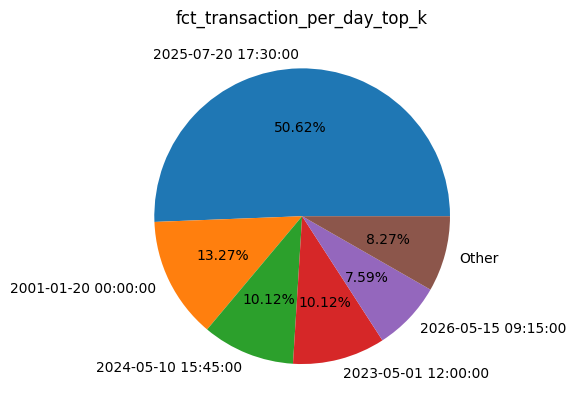

In [43]:
%sqlplot pie --table fct_transaction_per_day_top_k --column date ventes -S

## Find the Most Profitable Product

To find the most profitable product, we will group the data by the product and
sum the profit similarly to the previous step. But additionally, we will be
using a `PIVOT` clause to pivot the data and get the profit generated by each
product in each day per client.

In [44]:
%%sql --save fct_transaction_per_client
SELECT
    date,
    client_id,
    product_type,
    SUM(product_price * product_quantity) AS ventes
FROM
    fct_transaction_with_synthetic
INNER JOIN
    dim_product_nomenclature
USING
    (product_id)
GROUP BY
    date,
    client_id,
    product_type

Generating CTE with stored snippets: 'dim_product_nomenclature', and 'fct_transaction_with_synthetic'

Running query in 'duckdb:///:default:'

,date,client_id,product_type,ventes
0,2022-12-31 18:00:00,9876,DECO,44.97
1,2023-06-01 10:30:00,24680,MEUBLE,31.98
2,2023-08-12 14:30:00,54321,DECO,104.95
3,2001-01-20 00:00:00,999,DECO,14.24
4,2001-01-20 00:00:00,845,DECO,60.00
5,2023-09-18 12:45:00,9876543,DECO,44.97
6,2023-05-01 12:00:00,24680,MEUBLE,399.90
7,2024-05-10 15:45:00,5678,MEUBLE,400.00
8,2025-07-20 17:30:00,13579,MEUBLE,1999.80
9,2001-01-20 00:00:00,999,MEUBLE,50.00


In [45]:
%%sql --with fct_transaction_per_client --save fct_transaction_per_client_pivot
SELECT
    client_id,
    MEUBLE AS ventes_meuble,
    DECO AS ventes_deco,
FROM (
    PIVOT fct_transaction_per_client
    ON
        product_type IN (SELECT DISTINCT product_type FROM dim_product_nomenclature)
    USING
        SUM(ventes)
    GROUP BY
        client_id
)

Running query in 'duckdb:///:default:'

,client_id,ventes_meuble,ventes_deco
0,9876543,NaN,44.97
1,987,NaN,100.00
2,13579,1999.80,NaN
3,24680,731.78,NaN
4,5678,400.00,NaN
5,845,400.00,60.00
6,9876,NaN,44.97
7,999,50.00,14.24
8,54321,NaN,104.95
